# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

C:\Users\bchou\Miniconda3\envs\RoboND\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable}_conv2d_batchnorm() function.
    
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    print("\tSmall IP layer: {}".format(small_ip_layer.shape))

    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsample_layer = bilinear_upsample(small_ip_layer)
    print("\tUpsample Layer: {}".format(upsample_layer.shape))
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    # If statement added to allow for skip layers
    if large_ip_layer == None:
        concatenate_layer = upsample_layer
    else:
        concatenate_layer = layers.concatenate([upsample_layer, large_ip_layer])
        print("\tLarge IP layer: {}".format(large_ip_layer.shape))
    


    print("\tConcatenate Layer: {}".format(concatenate_layer.shape))
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenate_layer, filters)
    print("\tSeperable Conv layer 1: {}".format(output_layer.shape))
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
#3 layers
def fcn_model(inputs, num_classes):
    
    print("Input: {}".format(inputs.shape))
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    en_filter = (32,64,128)

    en_strides = (2,2,2)
    en_layer_1 = encoder_block(inputs, en_filter[0],en_strides[0])
    print("Encoder layer 1: {}".format(en_layer_1.shape))
    en_layer_2 = encoder_block(en_layer_1, en_filter[1], en_strides[1])
    print("EN layer 2: {}".format(en_layer_2.shape))
    en_layer_3 = encoder_block(en_layer_2, en_filter[2], en_strides[2])
    print("En layer 3: {}".format(en_layer_3.shape))

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    
    convolution_layer = conv2d_batchnorm(en_layer_3, 256, kernel_size = 1, strides = 1) #512 bugged
    
    print("FCN convo layer: {}".format(convolution_layer.shape))
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    
    de_filter = en_filter[::-1]
    
    de_layer_1 = decoder_block(convolution_layer, None, de_filter[1])
    print("Decoder Layer 1: {}".format(de_layer_1.shape))
    de_layer_2 = decoder_block(de_layer_1, en_layer_1, de_filter[2])
    print("Decoder Layer 2: {}".format(de_layer_2.shape))
    x = decoder_block(de_layer_2, inputs, num_classes)
    print("Output FCN: {}".format(x.shape))
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256 #original 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Input: (?, 256, 256, 3)
Encoder layer 1: (?, 128, 128, 32)
EN layer 2: (?, 64, 64, 64)
En layer 3: (?, 32, 32, 128)
FCN convo layer: (?, 32, 32, 256)
	Small IP layer: (?, 32, 32, 256)
	Upsample Layer: (?, 64, 64, 256)
	Concatenate Layer: (?, 64, 64, 256)
	Seperable Conv layer 1: (?, 64, 64, 64)
Decoder Layer 1: (?, 64, 64, 64)
	Small IP layer: (?, 64, 64, 64)
	Upsample Layer: (?, 128, 128, 64)
	Large IP layer: (?, 128, 128, 32)
	Concatenate Layer: (?, 128, 128, 96)
	Seperable Conv layer 1: (?, 128, 128, 32)
Decoder Layer 2: (?, 128, 128, 32)
	Small IP layer: (?, 128, 128, 32)
	Upsample Layer: (?, 256, 256, 32)
	Large IP layer: (?, 256, 256, 3)
	Concatenate Layer: (?, 256, 256, 35)
	Seperable Conv layer 1: (?, 256, 256, 3)
Output FCN: (?, 256, 256, 3)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [10]:
learning_rate = 0.0005
batch_size = 16
num_epochs = 50
steps_per_epoch = 260
validation_steps = 100
workers = 12

Epoch 1/50
259/260 [============================>.] - ETA: 0s - loss: 0.9426

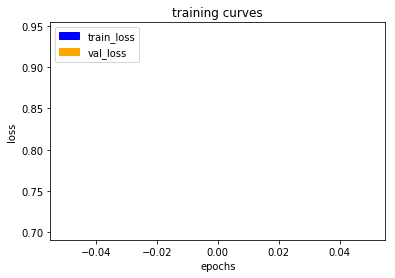

260/260 [==============================] - 152s - loss: 0.9418 - val_loss: 0.7030
Epoch 2/50
259/260 [============================>.] - ETA: 0s - loss: 0.5585

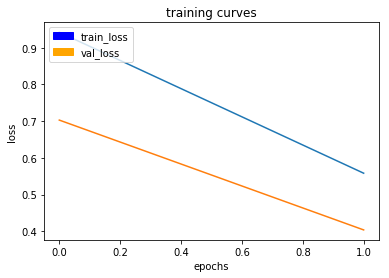

260/260 [==============================] - 150s - loss: 0.5579 - val_loss: 0.4038
Epoch 3/50
259/260 [============================>.] - ETA: 0s - loss: 0.3022

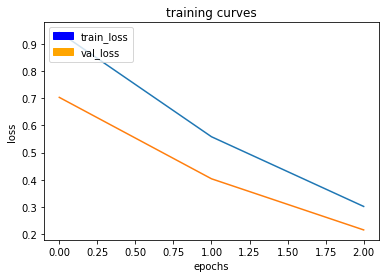

260/260 [==============================] - 150s - loss: 0.3019 - val_loss: 0.2159
Epoch 4/50
259/260 [============================>.] - ETA: 0s - loss: 0.1701

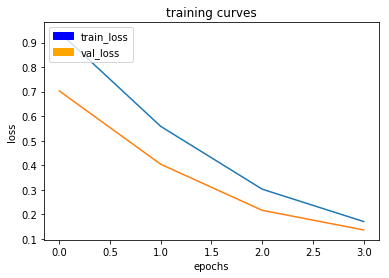

260/260 [==============================] - 148s - loss: 0.1700 - val_loss: 0.1359
Epoch 5/50
259/260 [============================>.] - ETA: 0s - loss: 0.1083

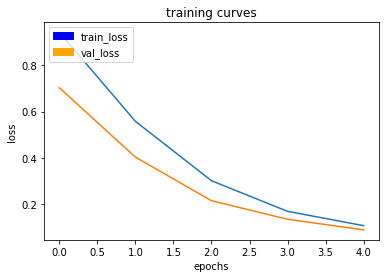

260/260 [==============================] - 148s - loss: 0.1083 - val_loss: 0.0900
Epoch 6/50
259/260 [============================>.] - ETA: 0s - loss: 0.0776

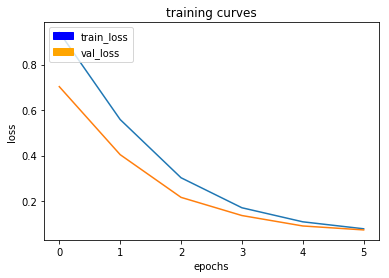

260/260 [==============================] - 150s - loss: 0.0775 - val_loss: 0.0726
Epoch 7/50
259/260 [============================>.] - ETA: 0s - loss: 0.0604

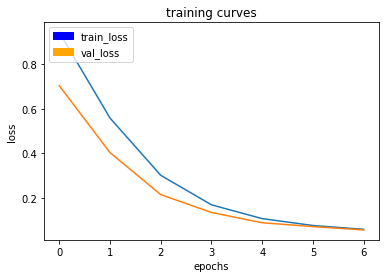

260/260 [==============================] - 147s - loss: 0.0604 - val_loss: 0.0578
Epoch 8/50
259/260 [============================>.] - ETA: 0s - loss: 0.0500

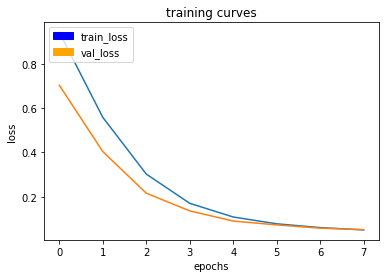

260/260 [==============================] - 147s - loss: 0.0500 - val_loss: 0.0513
Epoch 9/50
259/260 [============================>.] - ETA: 0s - loss: 0.0431

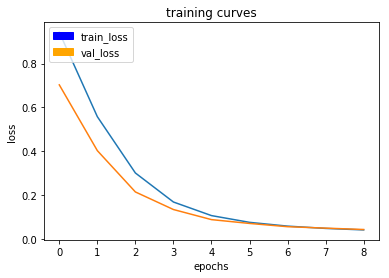

260/260 [==============================] - 148s - loss: 0.0431 - val_loss: 0.0450
Epoch 10/50
259/260 [============================>.] - ETA: 0s - loss: 0.0392

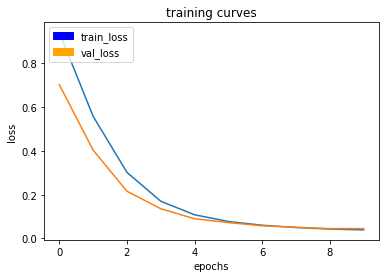

260/260 [==============================] - 148s - loss: 0.0392 - val_loss: 0.0450
Epoch 11/50
259/260 [============================>.] - ETA: 0s - loss: 0.0357

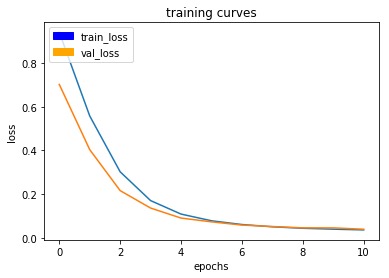

260/260 [==============================] - 148s - loss: 0.0357 - val_loss: 0.0388
Epoch 12/50
259/260 [============================>.] - ETA: 0s - loss: 0.0323

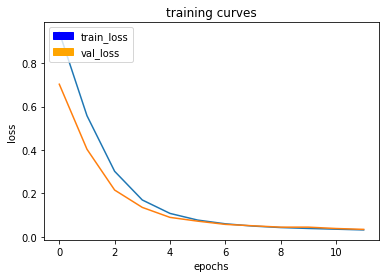

260/260 [==============================] - 147s - loss: 0.0323 - val_loss: 0.0348
Epoch 13/50
259/260 [============================>.] - ETA: 0s - loss: 0.0308

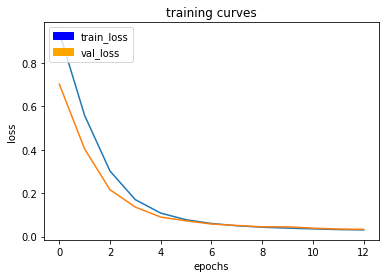

260/260 [==============================] - 148s - loss: 0.0308 - val_loss: 0.0335
Epoch 14/50
259/260 [============================>.] - ETA: 0s - loss: 0.0292

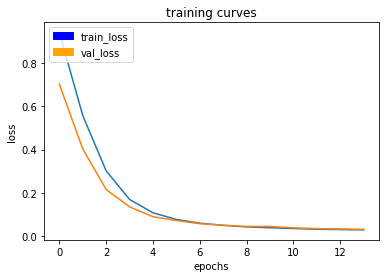

260/260 [==============================] - 150s - loss: 0.0291 - val_loss: 0.0321
Epoch 15/50
259/260 [============================>.] - ETA: 0s - loss: 0.0281

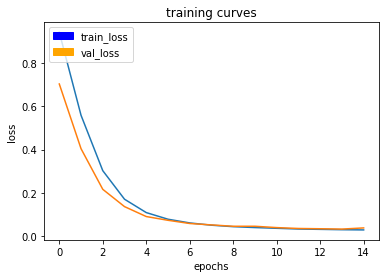

260/260 [==============================] - 148s - loss: 0.0281 - val_loss: 0.0374
Epoch 16/50
259/260 [============================>.] - ETA: 0s - loss: 0.0270

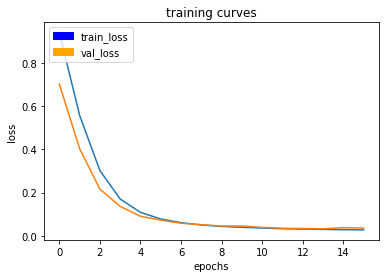

260/260 [==============================] - 148s - loss: 0.0269 - val_loss: 0.0353
Epoch 17/50
259/260 [============================>.] - ETA: 0s - loss: 0.0266

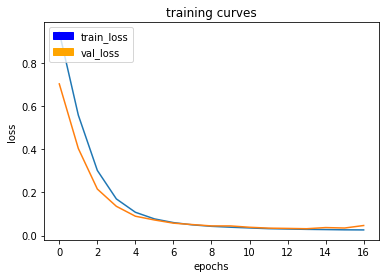

260/260 [==============================] - 150s - loss: 0.0265 - val_loss: 0.0470
Epoch 18/50
259/260 [============================>.] - ETA: 0s - loss: 0.0247

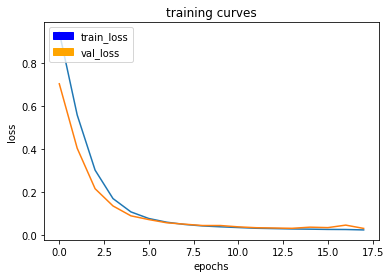

260/260 [==============================] - 149s - loss: 0.0247 - val_loss: 0.0316
Epoch 19/50
259/260 [============================>.] - ETA: 0s - loss: 0.0248

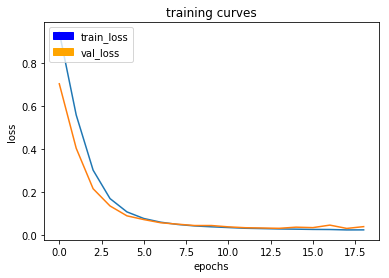

260/260 [==============================] - 149s - loss: 0.0248 - val_loss: 0.0399
Epoch 20/50
259/260 [============================>.] - ETA: 0s - loss: 0.0240

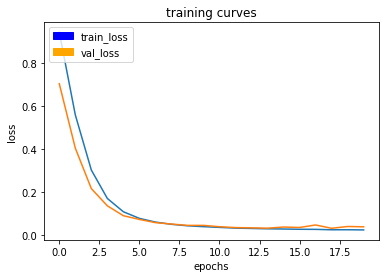

260/260 [==============================] - 151s - loss: 0.0240 - val_loss: 0.0384
Epoch 21/50
259/260 [============================>.] - ETA: 0s - loss: 0.0232

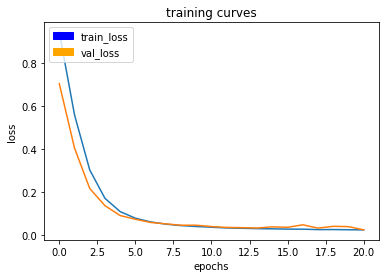

260/260 [==============================] - 149s - loss: 0.0232 - val_loss: 0.0236
Epoch 22/50
259/260 [============================>.] - ETA: 0s - loss: 0.0225

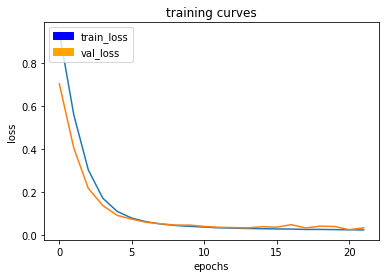

260/260 [==============================] - 150s - loss: 0.0225 - val_loss: 0.0321
Epoch 23/50
259/260 [============================>.] - ETA: 0s - loss: 0.0223

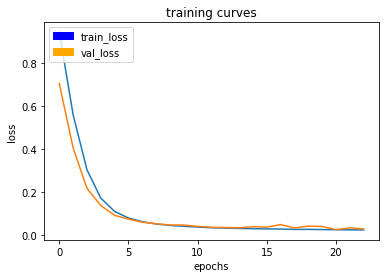

260/260 [==============================] - 149s - loss: 0.0223 - val_loss: 0.0265
Epoch 24/50
259/260 [============================>.] - ETA: 0s - loss: 0.0211

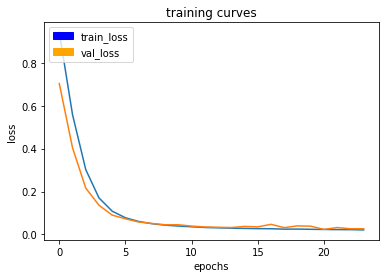

260/260 [==============================] - 149s - loss: 0.0210 - val_loss: 0.0266
Epoch 25/50
259/260 [============================>.] - ETA: 0s - loss: 0.0214

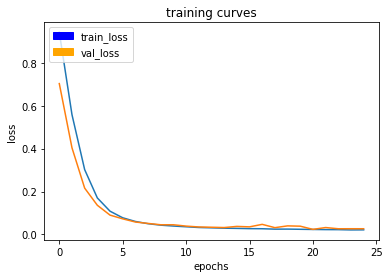

260/260 [==============================] - 151s - loss: 0.0214 - val_loss: 0.0265
Epoch 26/50
259/260 [============================>.] - ETA: 0s - loss: 0.0212

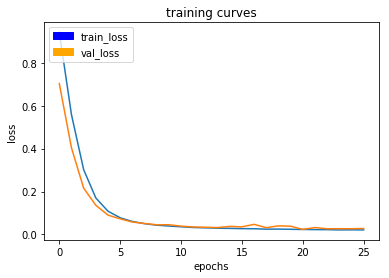

260/260 [==============================] - 150s - loss: 0.0211 - val_loss: 0.0276
Epoch 27/50
259/260 [============================>.] - ETA: 0s - loss: 0.0218

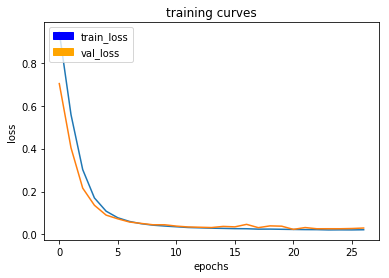

260/260 [==============================] - 149s - loss: 0.0218 - val_loss: 0.0299
Epoch 28/50
259/260 [============================>.] - ETA: 0s - loss: 0.0208

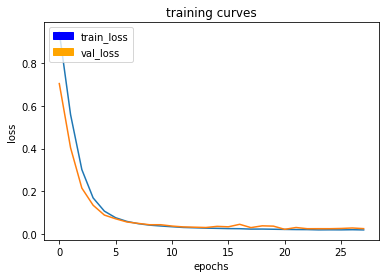

260/260 [==============================] - 153s - loss: 0.0208 - val_loss: 0.0268
Epoch 29/50
259/260 [============================>.] - ETA: 0s - loss: 0.0200

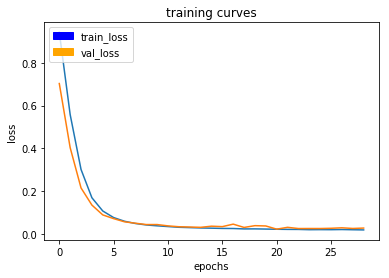

260/260 [==============================] - 152s - loss: 0.0200 - val_loss: 0.0286
Epoch 30/50
259/260 [============================>.] - ETA: 0s - loss: 0.0199

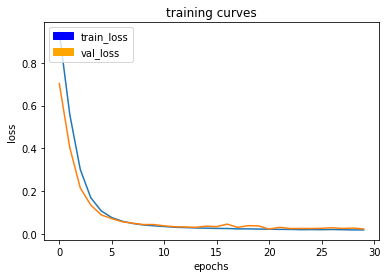

260/260 [==============================] - 151s - loss: 0.0199 - val_loss: 0.0244
Epoch 31/50
259/260 [============================>.] - ETA: 0s - loss: 0.0198

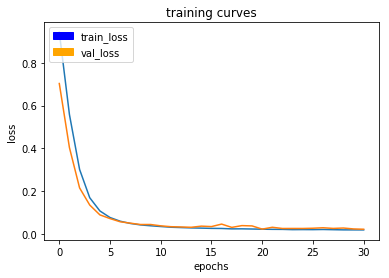

260/260 [==============================] - 152s - loss: 0.0198 - val_loss: 0.0230
Epoch 32/50
259/260 [============================>.] - ETA: 0s - loss: 0.0201

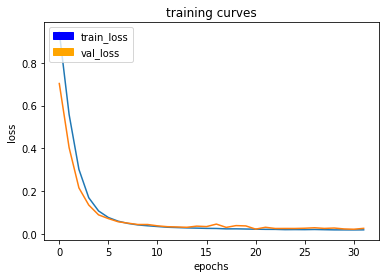

260/260 [==============================] - 152s - loss: 0.0201 - val_loss: 0.0271
Epoch 33/50
259/260 [============================>.] - ETA: 0s - loss: 0.0206

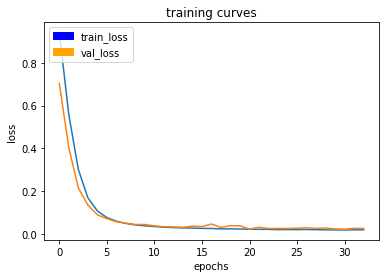

260/260 [==============================] - 152s - loss: 0.0206 - val_loss: 0.0266
Epoch 34/50
259/260 [============================>.] - ETA: 0s - loss: 0.0187

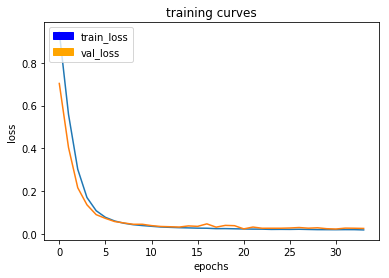

260/260 [==============================] - 150s - loss: 0.0187 - val_loss: 0.0256
Epoch 35/50
259/260 [============================>.] - ETA: 0s - loss: 0.0189

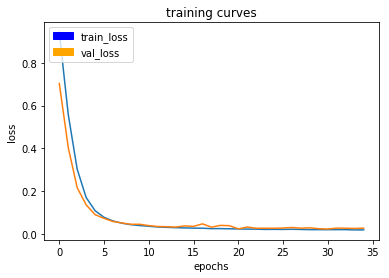

260/260 [==============================] - 153s - loss: 0.0189 - val_loss: 0.0270
Epoch 36/50
259/260 [============================>.] - ETA: 0s - loss: 0.0183

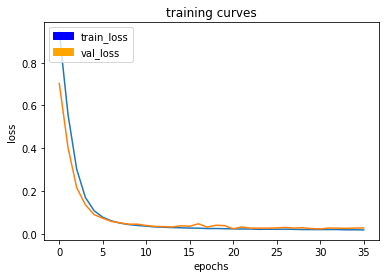

260/260 [==============================] - 149s - loss: 0.0183 - val_loss: 0.0276
Epoch 37/50
259/260 [============================>.] - ETA: 0s - loss: 0.0184

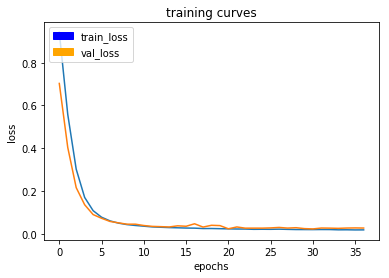

260/260 [==============================] - 151s - loss: 0.0184 - val_loss: 0.0270
Epoch 38/50
259/260 [============================>.] - ETA: 0s - loss: 0.0189

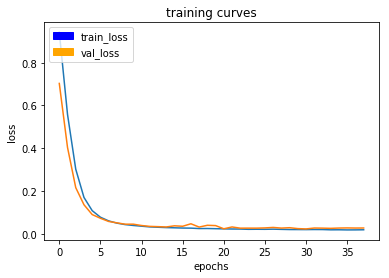

260/260 [==============================] - 153s - loss: 0.0189 - val_loss: 0.0272
Epoch 39/50
259/260 [============================>.] - ETA: 0s - loss: 0.0173

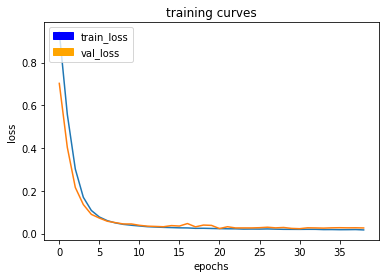

260/260 [==============================] - 153s - loss: 0.0173 - val_loss: 0.0264
Epoch 40/50
259/260 [============================>.] - ETA: 0s - loss: 0.0183

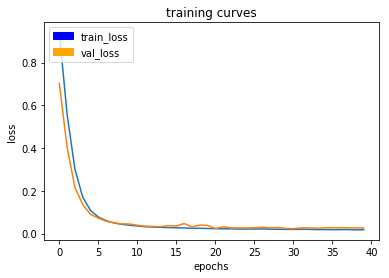

260/260 [==============================] - 153s - loss: 0.0183 - val_loss: 0.0266
Epoch 41/50
259/260 [============================>.] - ETA: 0s - loss: 0.0171

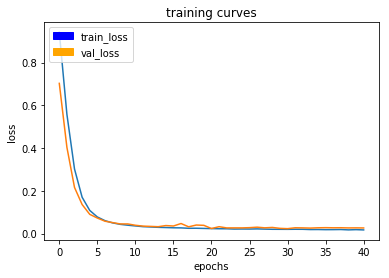

260/260 [==============================] - 152s - loss: 0.0170 - val_loss: 0.0262
Epoch 42/50
259/260 [============================>.] - ETA: 0s - loss: 0.0178

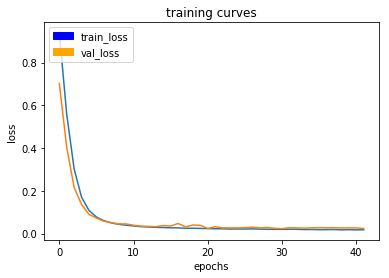

260/260 [==============================] - 153s - loss: 0.0178 - val_loss: 0.0235
Epoch 43/50
259/260 [============================>.] - ETA: 0s - loss: 0.0169

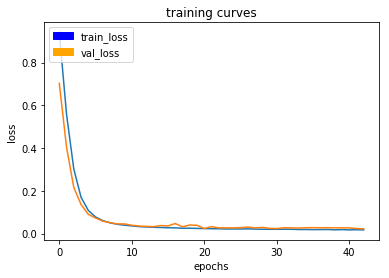

260/260 [==============================] - 154s - loss: 0.0169 - val_loss: 0.0222
Epoch 44/50
259/260 [============================>.] - ETA: 0s - loss: 0.0178

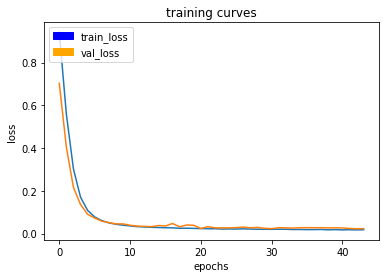

260/260 [==============================] - 150s - loss: 0.0178 - val_loss: 0.0229
Epoch 45/50
259/260 [============================>.] - ETA: 0s - loss: 0.0180

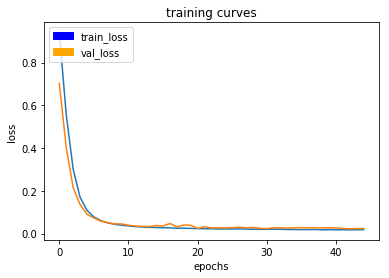

260/260 [==============================] - 150s - loss: 0.0180 - val_loss: 0.0234
Epoch 46/50
259/260 [============================>.] - ETA: 0s - loss: 0.0164

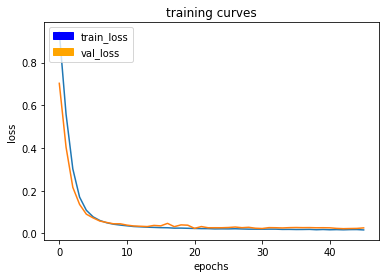

260/260 [==============================] - 153s - loss: 0.0164 - val_loss: 0.0259
Epoch 47/50
259/260 [============================>.] - ETA: 0s - loss: 0.0166

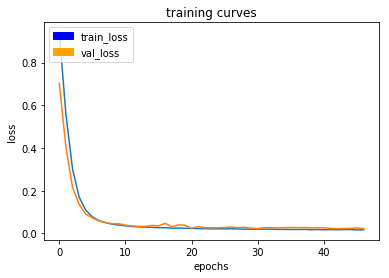

260/260 [==============================] - 152s - loss: 0.0166 - val_loss: 0.0228
Epoch 48/50
259/260 [============================>.] - ETA: 0s - loss: 0.0174

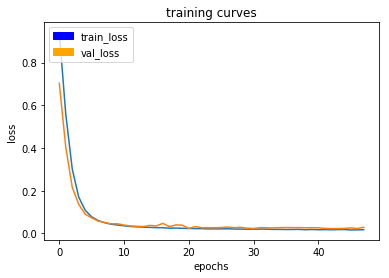

260/260 [==============================] - 150s - loss: 0.0174 - val_loss: 0.0286
Epoch 49/50
259/260 [============================>.] - ETA: 0s - loss: 0.0154

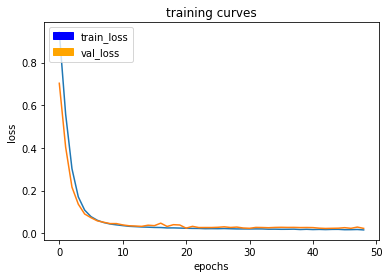

260/260 [==============================] - 151s - loss: 0.0154 - val_loss: 0.0225
Epoch 50/50
259/260 [============================>.] - ETA: 0s - loss: 0.0165

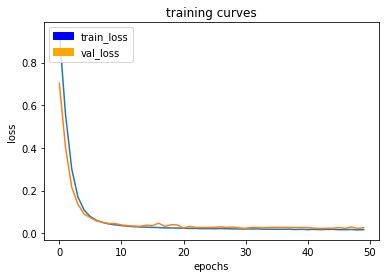

260/260 [==============================] - 152s - loss: 0.0165 - val_loss: 0.0254


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [12]:
# Save your trained model weights
weight_file_name = 'model_weights_project_final'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [13]:
run_num = 'run_project'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

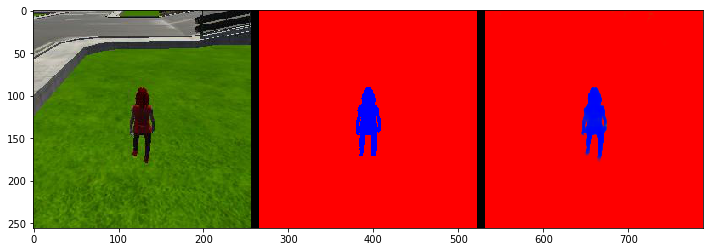

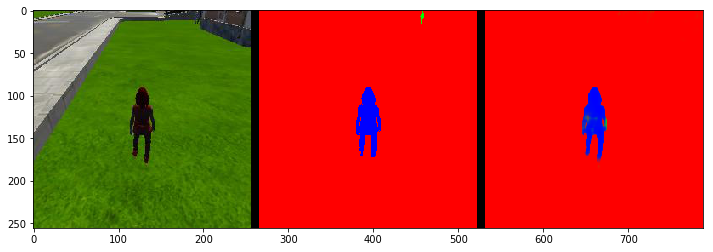

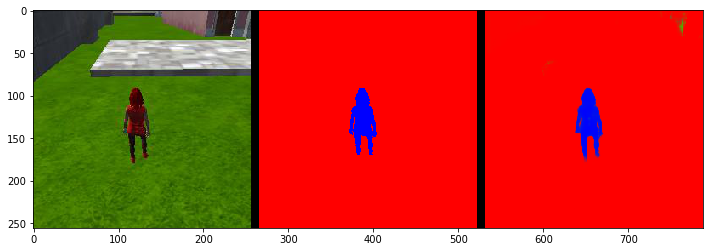

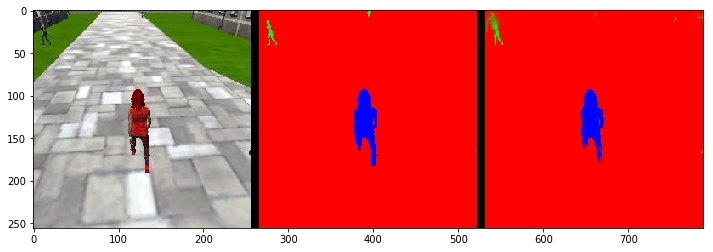

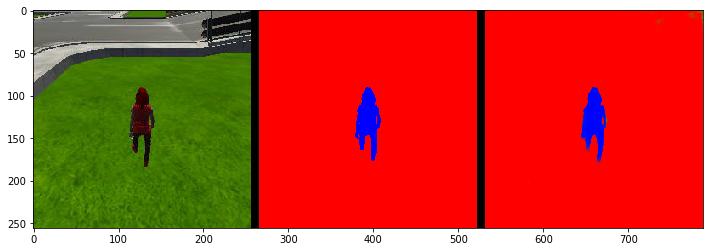

In [14]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 

for i in range(5):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

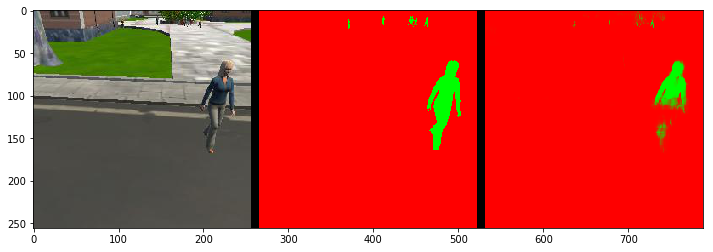

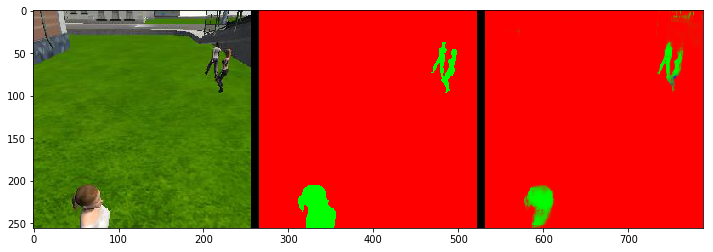

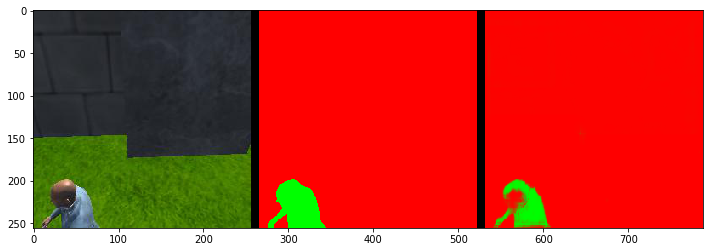

In [15]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

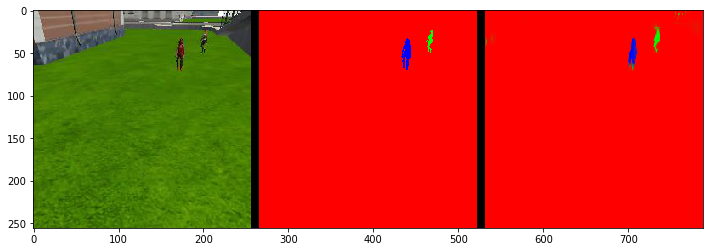

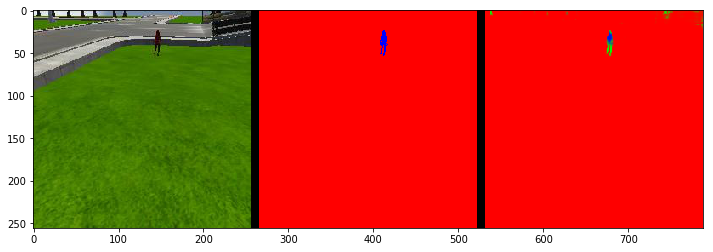

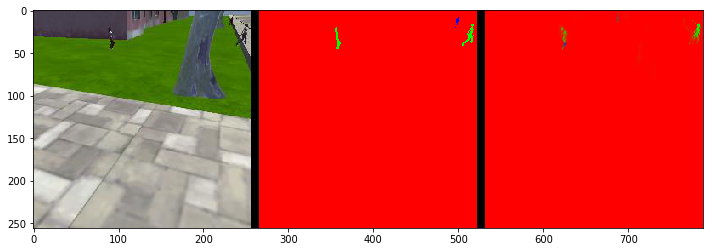

In [5]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [17]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9959154557894134
average intersection over union for other people is 0.3541533547125184
average intersection over union for the hero is 0.9134987692542778
number true positives: 539, number false positives: 0, number false negatives: 0


In [18]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9854571826539816
average intersection over union for other people is 0.7017663380246053
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 105, number false negatives: 0


In [19]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9964300445159741
average intersection over union for other people is 0.44434120275404926
average intersection over union for the hero is 0.25363870429037216
number true positives: 157, number false positives: 1, number false negatives: 155


In [20]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7272727272727273


In [21]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.583568736772325


In [22]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.42441362674350913
